## Import Modules & Data

In [1]:
import pandas as pd

In [74]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')
links_df = pd.read_csv('data/links.csv')

In [44]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Prepare data for `surprise` from sklearn

In [3]:
#%%capture
#pip install scikit-surprise

In [4]:
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [5]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [49]:
data = ratings_df[['userId', 'movieId', 'rating']]


# create surprise dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(data, reader)

In [50]:
# split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=142)

## Model to test

In [51]:
# model to test

sim_options = {
    'name': 'cosine',
    'user_based': True
}

knn = KNNBasic(sim_options=sim_options)

In [52]:
# train
knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [53]:
# predictions
predictions = knn.test(testset)

In [54]:
# explore
predictions[:5]

[Prediction(uid=380, iid=2085, r_ui=3.0, est=3.5191062895722083, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=367, iid=513, r_ui=4.0, est=2.9999999999999996, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=570, iid=349, r_ui=4.0, est=3.7123899526005637, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288, iid=2018, r_ui=3.0, est=3.391371971142089, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid=446, iid=266, r_ui=2.0, est=3.4014122408648797, details={'actual_k': 40, 'was_impossible': False})]

In [55]:
predictions_df = pd.DataFrame(predictions, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])
predictions_df.head()

,raw_user_id,raw_item_id,actual_user_rating,estimated_user_rating,details
0,380,2085,3.0,3.519106,"{'actual_k': 30, 'was_impossible': False}"
1,367,513,4.0,3.000000,"{'actual_k': 2, 'was_impossible': False}"
2,570,349,4.0,3.712390,"{'actual_k': 40, 'was_impossible': False}"
3,288,2018,3.0,3.391372,"{'actual_k': 29, 'was_impossible': False}"
4,446,266,2.0,3.401412,"{'actual_k': 40, 'was_impossible': False}"


In [56]:
# evaluation

accuracy.mae(predictions)

MAE:  0.7466


0.7465676186021254

In [57]:
accuracy.rmse(predictions)

RMSE: 0.9706


0.9706404973871133

In [58]:
accuracy.fcp(predictions)

FCP:  0.6685


0.6684847446082518

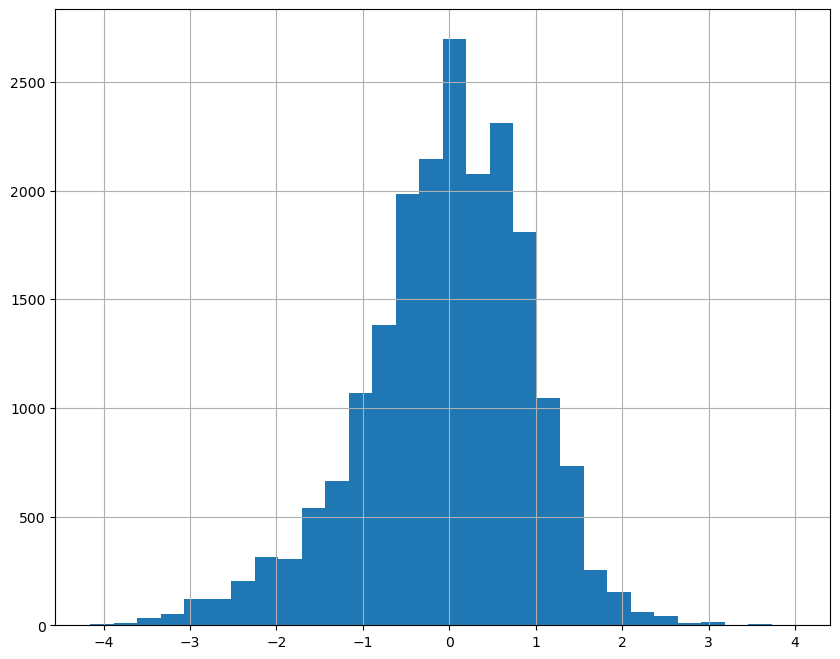

In [59]:
predictions_df["difference"] = predictions_df["actual_user_rating"] - predictions_df["estimated_user_rating"]

predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

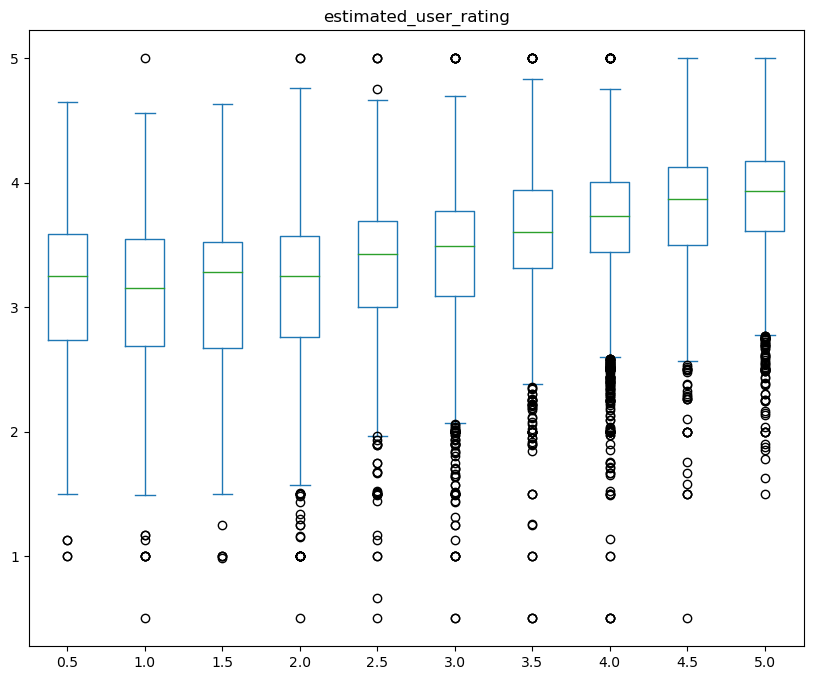

In [60]:
# boxplot of errors

predictions_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

<Axes: >

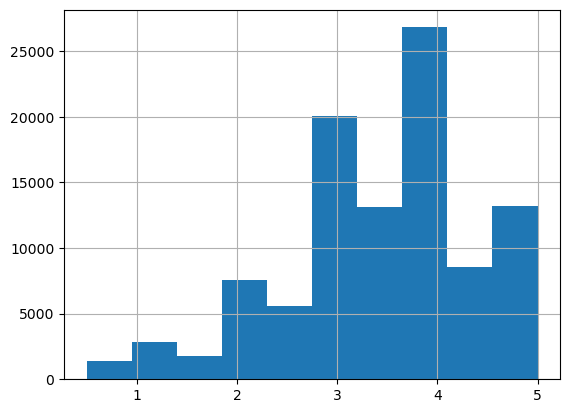

In [61]:
ratings_df.rating.hist()

In [62]:
ratings_df.rating.mean()

3.501556983616962

## Model to use

Our objective is to **generate predictions for items that the user has not yet rated**, leveraging the patterns observed from the items they have rated. To achieve this, we utilise the **build_full_trainset()** method. This method constructs a comprehensive training set encompassing all user-item ratings.

In [63]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# craete full train set
full_train = data.build_full_trainset()
algo = KNNBasic(sim_options=sim_options)
algo.fit(full_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


When using build_full_trainset, we pair it with build_anti_testset(). This method creates a test set for predicting items that users haven't rated yet. It simulates scenarios where the recommendation system suggests new items to users.

In [64]:
# create full test set
full_testset = full_train.build_anti_testset()

# make predictions for full test set
predictions = algo.test(full_testset)

In [65]:
predictions[:5]

[Prediction(uid=1, iid=318, r_ui=3.501556983616962, est=4.661919717891216, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.501556983616962, est=4.312341769109607, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1, iid=6874, r_ui=3.501556983616962, est=4.037832458711413, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1, iid=8798, r_ui=3.501556983616962, est=3.8254415343069, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1, iid=46970, r_ui=3.501556983616962, est=3.24878872930711, details={'actual_k': 28, 'was_impossible': False})]

In [66]:
len(predictions)

5830804

### Function : Top n predictions for specific user

In [67]:
def get_top_n(predictions, user_id, n=10):

  user_recommendations = []

  # Iterate through each prediction tuple
  for uid, iid, true_r, est, _ in predictions:
    # Check if the user ID matches the target user
    if user_id == uid:
      # Append item_id and estimated_rating to the user_recommendations list
      user_recommendations.append((iid, est))
    else:
      # Skip to the next prediction if user ID doesn't match
      continue

  # Sort the user_recommendations list based on estimated_rating in descending order
  ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)

  # Get the top n predictions from the ordered_recommendations
  ordered_recommendations_top_n = ordered_recommendations[:n]

  return ordered_recommendations_top_n

In [68]:
user_id = 1
n = 10

top_n = get_top_n(predictions, user_id, n)
top_n

[(131724, 5),
 (5746, 5),
 (6835, 5),
 (3851, 5),
 (1151, 5),
 (1631, 5),
 (2075, 5),
 (176601, 5),
 (92494, 5),
 (102217, 5)]

In [69]:
# get movie names


# Creating a DataFrame from the top_n tuples with columns 'movieId' and 'estimated_rating'
tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])

# Creating a copy of the original DataFrame with duplicate 'movieId' entries removed
reduced_df = ratings_df.drop_duplicates(subset='movieId').copy()

# Merging the tuples_df with the reduced_df based on 'movieId', retaining only the matching rows
tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')

# merge tuples_df_expanded with movies_df
tuples_df_name = movies_df[['movieId','title','genres']].merge(tuples_df_expanded[['movieId','estimated_rating']], how='right')

# Selecting specific columns from the merged DataFrame to include in the final result
tuples_df_name = tuples_df_name[['movieId', 'title', 'genres','estimated_rating']]

# Displaying the expanded DataFrame with relevant book information
tuples_df_name

,movieId,title,genres,estimated_rating
0,131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary,5
1,5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi,5
2,6835,Alien Contamination (1980),Action|Horror|Sci-Fi,5
3,3851,I'm the One That I Want (2000),Comedy,5
4,1151,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy,5
5,1631,"Assignment, The (1997)",Action|Thriller,5
6,2075,Mephisto (1981),Drama|War,5
7,176601,Black Mirror,(no genres listed),5
8,92494,Dylan Moran: Monster (2004),Comedy|Documentary,5
9,102217,Bill Hicks: Revelations (1993),Comedy,5


## Function : Top movies with name: recommend to specific user

In [75]:
def top_n_user_based(predictions, user_id, n=10):

    user_recommendations = []

    # Iterate through each prediction tuple
    for uid, iid, true_r, est, _ in predictions:
        # Check if the user ID matches the target user
        if user_id == uid:
          # Append item_id and estimated_rating to the user_recommendations list
          user_recommendations.append((iid, est))
        else:
          # Skip to the next prediction if user ID doesn't match
          continue

    # Sort the user_recommendations list based on estimated_rating in descending order
    ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)

    # Get the top n predictions from the ordered_recommendations
    top_n = ordered_recommendations[:n]

    # Creating a DataFrame from the top_n tuples with columns 'movieId' and 'estimated_rating'
    tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])

    # Creating a copy of the original DataFrame with duplicate 'movieId' entries removed
    reduced_df = ratings_df.drop_duplicates(subset='movieId').copy()

    # Merging the tuples_df with the reduced_df based on 'movieId', retaining only the matching rows
    tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')

    # merge tuples_df_expanded with movies_df
    tuples_df_name = movies_df[['movieId','title','genres']].merge(tuples_df_expanded[['movieId','estimated_rating']], how='right')

    # Selecting specific columns from the merged DataFrame to include in the final result
    df_top_n = tuples_df_name[['movieId', 'title', 'genres']]

    # Displaying the expanded DataFrame with relevant book information
    df_top_n    

    return df_top_n

In [76]:
top_n_user_based(predictions, user_id=1,n=5) 

,movieId,title,genres
0,131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
1,5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi
2,6835,Alien Contamination (1980),Action|Horror|Sci-Fi
3,3851,I'm the One That I Want (2000),Comedy
4,1151,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy


In [77]:
top_n_user_based(predictions, user_id=35,n=5) 

,movieId,title,genres
0,685,It's My Party (1996),Drama
1,8235,Safety Last! (1923),Action|Comedy|Romance
2,26326,"Holy Mountain, The (Montaña sagrada, La) (1973)",Drama
3,96606,Samsara (2011),Documentary
4,1151,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy
